In [1]:
from load_atoms import load_dataset

structures = load_dataset("QM7")
structures

Output()

QM7:
    structures: 7,165
    atoms: 110,650
    species:
        H: 56.00%
        C: 32.32%
        N: 6.01%
        O: 5.40%
        S: 0.27%
    properties:
        per atom: ()
        per structure: (energy)

In [2]:
train, val, test = structures.random_split([0.8, 0.1, 0.1])
train[0]

Atoms(symbols='CNC5H13', pbc=False)

In [3]:
from graph_pes.data.io import to_atomic_graphs

train_graphs, val_graphs, test_graphs = (
    to_atomic_graphs(split, cutoff=5.0) for split in (train, val, test)
)
train_graphs[0]

AtomicGraph(atoms: 20, edges: 314, has_cell: False, labels: ['energy'])

## 2. Model

Before we instantiate our model, let's create a quick helper function to visualise the performance of our model on the training and test sets:

In [4]:
import matplotlib.pyplot as plt
from graph_pes.analysis import parity_plot
from graph_pes.core import GraphPESModel
from graph_pes.transform import divide_per_atom

%config InlineBackend.figure_format = 'retina'

def analyse_model(model: GraphPESModel):
    for name, data, colour in zip(
        ["Train", "Test"],
        [train_graphs, test_graphs],
        ["royalblue", "crimson"],
    ):
        parity_plot(
            model,
            data,
            transform=divide_per_atom,
            units="eV / atom",
            label=name,
            c=colour,
        )

    plt.legend(fancybox=False, loc="lower right")

In [5]:
import torch
from graph_pes.models import AdditionModel, LearnableOffset, SchNet

# ensure reproducibility
torch.manual_seed(0)

model = AdditionModel(
    schnet=SchNet(
        cutoff=5.0,
        node_features=10,
        expansion_features=10,
    ),
    offset=LearnableOffset(),
)
model

AdditionModel(
  schnet=SchNet(
    chemical_embedding=PerElementEmbedding(dim=10, elements=[]),
    interactions=UniformModuleList(
      (0-2): 3 x SchNetInteraction(
        (linear): Linear(in_features=10, out_features=10, bias=False)
        (cfconv): CFConv(
          Sequential(
            (0): GaussianSmearing(n_features=10, cutoff=5.0, trainable=True)
            (1): MLP(10 → 10 → 10, activation=ShiftedSoftplus())
          )
        )
        (mlp): MLP(10 → 10 → 10, activation=ShiftedSoftplus())
      )
    ),
    read_out=MLP(10 → 5 → 1, activation=ShiftedSoftplus()),
    per_element_scaling=PerElementParameter(trainable=True)
  ),
  offset=LearnableOffset(trainable=True)
)

We can see that the model has not been fitted yet, and performs poorly on the training and test sets, predicting energies that appear to be very close to zero:

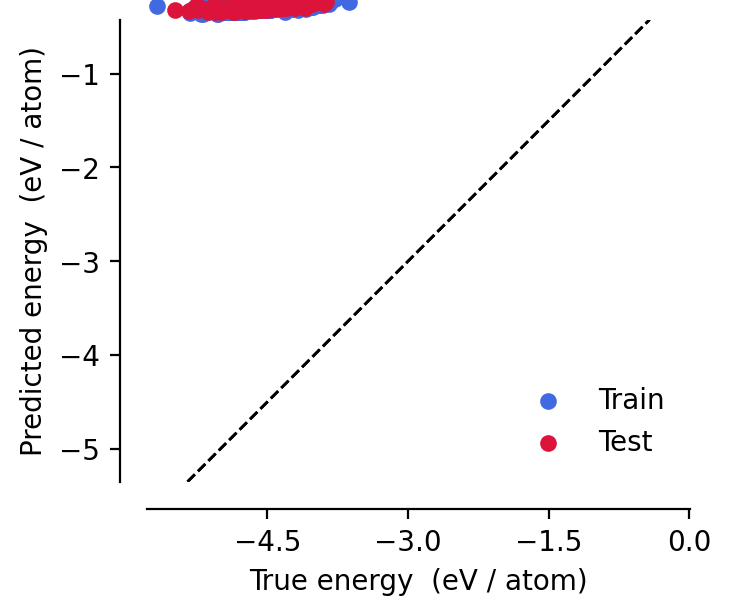

In [6]:
analyse_model(model)

In [7]:
model.pre_fit_all_components(train_graphs)
model

[graph-pes WARNING]: 
Estimated per-element energy offsets from the training data:
    PerElementParameter(trainable=True)
This will lead to a lack of guaranteed physicality in the model, 
since the energy of an isolated atom (and hence the behaviour of 
this model in the dissociation limit) is not guaranteed to be 
correct. Use a FixedOffset energy offset model if you require
and know the reference energy offsets.



AdditionModel(
  schnet=SchNet(
    chemical_embedding=PerElementEmbedding(
      dim=10,
      elements=['H', 'C', 'N', 'O', 'S']
    ),
    interactions=UniformModuleList(
      (0-2): 3 x SchNetInteraction(
        (linear): Linear(in_features=10, out_features=10, bias=False)
        (cfconv): CFConv(
          Sequential(
            (0): GaussianSmearing(n_features=10, cutoff=5.0, trainable=True)
            (1): MLP(10 → 10 → 10, activation=ShiftedSoftplus())
          )
        )
        (mlp): MLP(10 → 10 → 10, activation=ShiftedSoftplus())
      )
    ),
    read_out=MLP(10 → 5 → 1, activation=ShiftedSoftplus()),
    per_element_scaling=PerElementParameter({'H': 0.1, 'C': 0.592, 'N': 0.58, 'O': 0.49, 'S': 0.1}, trainable=True)
  ),
  offset=LearnableOffset({'H': -2.98, 'C': -6.68, 'N': -4.29, 'O': -4.25, 'S': -3.37}, trainable=True)
)

Analysing the model, we can see that this pre-fitting has drastically improved the model's performance for ~free! This makes the following training loop more robust.

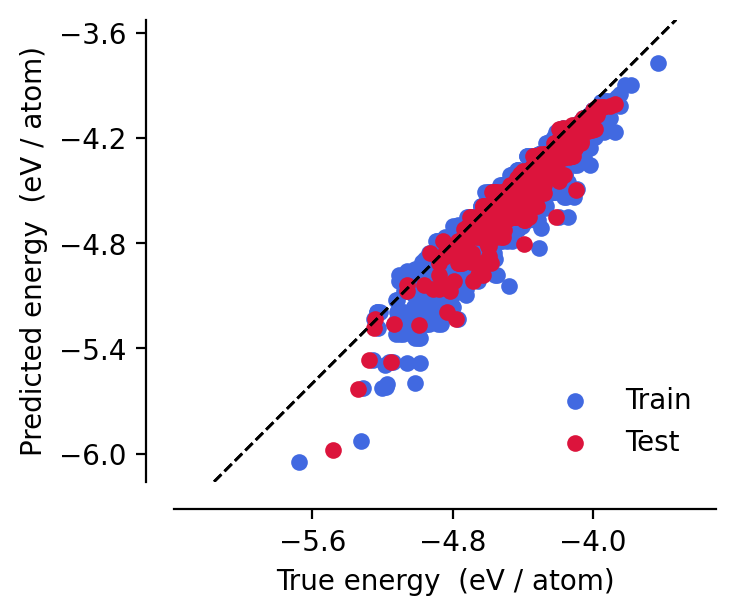

In [8]:
analyse_model(model)

In [9]:
from graph_pes.data.loader import GraphDataLoader
from graph_pes.graphs.operations import number_of_structures

# hyperparameters
accumulate_steps = 4
n_epochs = 25
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

# data-loaders
train_loader = GraphDataLoader(
    train_graphs,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = GraphDataLoader(
    val_graphs,
    batch_size=batch_size,
    shuffle=False,
)

# keep track of the best model
best_state_dict = {}
best_loss = float("inf")

# training loop
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    for index, batch in enumerate(train_loader):
        prediction = model.predict_energy(batch)
        ground_truth = batch["energy"]

        loss = (prediction - ground_truth).abs().mean()

        loss.backward()

        # accumulate gradients for `accumulate_steps` steps
        if (index + 1) % accumulate_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # validate every epoch
    model.eval()

    # NB
    # since we are only making energy predictions, we can save time and
    # memory by turning off gradient calculations - if you want to
    # calculate forces and stresses (using autograd internallly), you
    # can't use a torch.no_grad() context!
    with torch.no_grad():
        losses, batch_sizes = [], []
        for batch in val_loader:
            prediction = model.predict_energy(batch)
            ground_truth = batch["energy"]
            loss = (prediction - ground_truth).abs().mean()
            losses.append(loss.item())
            batch_sizes.append(number_of_structures(batch))

        avg_loss = sum(
            loss * batch_size for loss, batch_size in zip(losses, batch_sizes)
        ) / sum(batch_sizes)

    # save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_state_dict = model.state_dict()
        is_best = True
    else:
        is_best = False

    # log metrics
    print(
        f"Epoch {epoch + 1:02d}   ->   Val. loss: {avg_loss:.4f} (eV)",
        "*" if is_best else "",
    )


# load the best model
model.load_state_dict(best_state_dict)

Epoch 01   ->   Val. loss: 0.6773 (eV) *
Epoch 02   ->   Val. loss: 0.6021 (eV) *
Epoch 03   ->   Val. loss: 0.4627 (eV) *
Epoch 04   ->   Val. loss: 0.4079 (eV) *
Epoch 05   ->   Val. loss: 0.3291 (eV) *
Epoch 06   ->   Val. loss: 0.3297 (eV) 
Epoch 07   ->   Val. loss: 0.2644 (eV) *
Epoch 08   ->   Val. loss: 0.2699 (eV) 
Epoch 09   ->   Val. loss: 0.3282 (eV) 
Epoch 10   ->   Val. loss: 0.2494 (eV) *
Epoch 11   ->   Val. loss: 0.2546 (eV) 
Epoch 12   ->   Val. loss: 0.2673 (eV) 
Epoch 13   ->   Val. loss: 0.2476 (eV) *
Epoch 14   ->   Val. loss: 0.2041 (eV) *
Epoch 15   ->   Val. loss: 0.2162 (eV) 
Epoch 16   ->   Val. loss: 0.2434 (eV) 
Epoch 17   ->   Val. loss: 0.2577 (eV) 
Epoch 18   ->   Val. loss: 0.2200 (eV) 
Epoch 19   ->   Val. loss: 0.2087 (eV) 
Epoch 20   ->   Val. loss: 0.1956 (eV) *
Epoch 21   ->   Val. loss: 0.1983 (eV) 
Epoch 22   ->   Val. loss: 0.2091 (eV) 
Epoch 23   ->   Val. loss: 0.1972 (eV) 
Epoch 24   ->   Val. loss: 0.2212 (eV) 
Epoch 25   ->   Val. loss: 0.1

<All keys matched successfully>

Unsurprisingly, training has improved this toy model's performance:

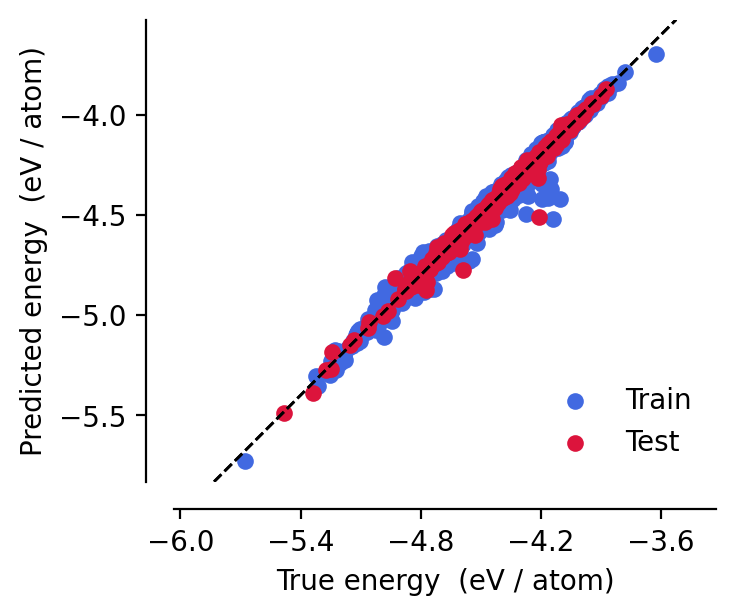

In [10]:
analyse_model(model)
plt.savefig("parity-plot.svg", bbox_inches="tight");